In [8]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("Cuda Not Avalable")
else:
    print("Cuda Avalable")
    



Cuda Avalable


Datataset

In [9]:
num_workers = 0
batch_size = 20
valid_size = 0.2

data_dir = "dataset/flower_data"

transform = transforms.Compose([transforms.Resize(256),
                               transforms.RandomResizedCrop(256),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(10),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

train_data = datasets.ImageFolder(data_dir+"/train",transform=transform)
test_data = datasets.ImageFolder(data_dir+"/valid",transform=transform)


num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx,valid_idx = indices[split:],indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler =SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,
                                          num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=valid_sampler,
                                          num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)






In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) 

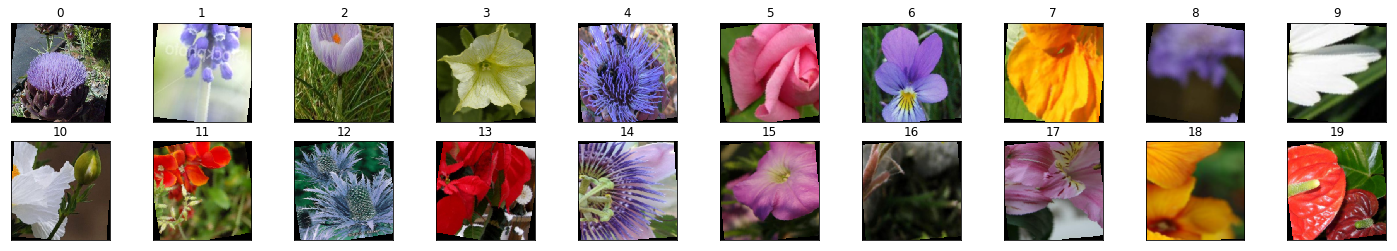

In [11]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(idx)

In [15]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        # convolutions
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        self.conv4 = nn.Conv2d(64,128,3,padding=1)
        
        # Max-pool
        self.pool = nn.MaxPool2d(2,2)
        
        # Dropout
        self.dropout = nn.Dropout(p=0.3)
        # Linear Layer
        self.fc1 = nn.Linear(16*16*128,1024)
        self.fc2 = nn.Linear(1024,512)
        
        # output
        self.out = nn.Linear(512,102)
        
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        x = x.view(-1,16*16*128)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        
        out = self.out(x)
        
        return out
    
    
model =Network()
print(model)

if train_on_gpu:
    model.cuda()
        
        
        

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3)
  (fc1): Linear(in_features=32768, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=102, bias=True)
)


In [20]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),lr =0.001)

In [21]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 3.120397 	Validation Loss: 0.737070
Validation loss decreased (inf --> 0.737070).  Saving model ...
Epoch: 2 	Training Loss: 2.888531 	Validation Loss: 0.693914
Validation loss decreased (0.737070 --> 0.693914).  Saving model ...
Epoch: 3 	Training Loss: 2.742078 	Validation Loss: 0.679490
Validation loss decreased (0.693914 --> 0.679490).  Saving model ...
Epoch: 4 	Training Loss: 2.630274 	Validation Loss: 0.638221
Validation loss decreased (0.679490 --> 0.638221).  Saving model ...
Epoch: 5 	Training Loss: 2.534418 	Validation Loss: 0.617630
Validation loss decreased (0.638221 --> 0.617630).  Saving model ...
Epoch: 6 	Training Loss: 2.458354 	Validation Loss: 0.598659
Validation loss decreased (0.617630 --> 0.598659).  Saving model ...
Epoch: 7 	Training Loss: 2.379760 	Validation Loss: 0.587800
Validation loss decreased (0.598659 --> 0.587800).  Saving model ...
Epoch: 8 	Training Loss: 2.344569 	Validation Loss: 0.556327
Validation loss decreased (0.58780

In [22]:
model.load_state_dict(torch.load('model_augmented.pt'))

In [61]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
#     correct =correct.view(correct.shape[0])
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
#         print(len(class_correct),correct.shape,label.item(),correct[i].item())
        try:
            class_correct[label.item()-1] += correct[i].item()
            class_total[label.item()] += 1
        except:
            break
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(batch_size):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            i, 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 2.136244

Test Accuracy of     0: 12% ( 1/ 8)
Test Accuracy of     1: 150% ( 6/ 4)
Test Accuracy of     2: 16% ( 1/ 6)
Test Accuracy of     3: 20% ( 1/ 5)
Test Accuracy of     4:  0% ( 0/ 6)
Test Accuracy of     5: 20% ( 2/10)
Test Accuracy of     6: 40% ( 2/ 5)
Test Accuracy of     7: 20% ( 1/ 5)
Test Accuracy of     8: 600% ( 6/ 1)
Test Accuracy of     9: 71% ( 5/ 7)


IndexError: list index out of range

NameError: name 'classes' is not defined

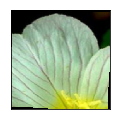

In [62]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))